In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# from collections import Counter
# from wordcloud import WordCloud

# from IPython.display import display, HTML

np.set_printoptions(suppress=True)

In [5]:
df_train = pd.read_csv('../../../../data/train.csv')
df_test = pd.read_csv('../../../../data/test.csv')

/tmp/ipykernel_178464/3946945178.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../../../../data/train.csv')


In [ ]:
def classify_cardinality_by_ratio(df, low_thresh=0.1, high_thresh=0.5):
    cardinality_info = []

    total_rows = len(df)

    for col in df.columns:
        n_unique = df[col].nunique()

        ratio = n_unique / total_rows

        if ratio <= low_thresh:
            level = 'Low'
        elif ratio <= high_thresh:
            level = 'Medium'
        else:
            level = 'High'
        
        cardinality_info.append((col, n_unique, f"{ratio*100:.2f}%", level))
    return pd.DataFrame(cardinality_info, columns=['Feature', 'Unique Values', 'Unique Percent', 'Cardinality Level'])

def visualize_samples_count(df, feature_name):
    value_counts = df[feature_name].value_counts()

    top_n = 30

    plt.figure(figsize=(10, 5))
    value_counts.head(top_n).plot(kind='bar', color='skyblue')

    plt.title(f'{feature_name} Top {top_n} Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.xticks(rotation=75, ha='right')
    plt.show()

def visualize_samples_target_mean(df, feature_name):
    plt.figure(figsize=(10, 5))

    top_n = 30
    group = df.groupby(feature_name)['target'].mean().sort_values(ascending=False).head(top_n)
    sns.barplot(x=group.index, y=group.values)
    plt.title(f"Mean of target by {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel(f"Mean target")
    plt.xticks(rotation=75, ha='right')
    plt.tight_layout()
    plt.show()

def find_rare_classes(df, feature_name, threshold=0.01):
    value_counts = df[feature_name].value_counts(normalize=True)
    rare_classes = value_counts[value_counts < threshold]

    return rare_classes

def print_samples(df, feature_name):
    value_counts = df[feature_name].value_counts()
    unique_count = df[feature_name].nunique()

    print_n = 10
    if unique_count <= print_n:
        total_count = value_counts.sum()

        for value, count in value_counts.items():
            percent = (count / total_count) * 100
            print(f"{str(value).ljust(15)} : {count:,}, ({percent:.2f}%)")
    else:
        head_n_values = value_counts.head(print_n // 2)
        tail_n_values = value_counts.tail(print_n // 2)

        head_n_dict = head_n_values.to_dict()
        tail_n_dict = tail_n_values.to_dict()

        total_count = value_counts.sum()

        for word, count in head_n_dict.items():
            percent = (count / total_count) * 100
            print(f"{str(word).ljust(15)} : {count:,}, ({percent:.2f}%)")
        print('...')
        for word, count in tail_n_dict.items():
            percent = (count / total_count) * 100
            print(f"{str(word).ljust(15)} : {count:,}, ({percent:.2f}%)")


def feature_summary(df, feature_name, custom_missing_value):
    print(" " * 50)
    print("=" * 50)
    print(f"[ {feature_name} ]")
    print(" " * 50)
    print(f"{'-'*20} Statistics Values {'-'*20}")  

    missing_value_num = ((df[feature_name] == "") | (df[feature_name] == " ")).sum()
    missing_value_num += df[feature_name].apply(lambda x: isinstance(x, float) and pd.isna(x)).sum()
    missing_value_num += df[feature_name].apply(lambda x: x is pd.NA).sum()
    missing_value_num += df[feature_name].apply(lambda x: x is None).sum()
    
    for missing_value in custom_missing_value:
        missing_value_num += (df[feature_name] == missing_value).sum()

    print(f"Unique          : {df[feature_name].nunique()}")
    print(f"Unique (%)      : {(df[feature_name].nunique() / df[feature_name].shape[0]) * 100:.2f}%")
    print(f'Missing         : {missing_value_num}')
    print(f'Missing (%)     : {(missing_value_num / df[feature_name].shape[0]) * 100:.2f}%')
    print(f'Memory size     : {df[feature_name].memory_usage(deep=True) / (1024 ** 2):.2f} MB')
    print(f'Rare Classes    : {len(find_rare_classes(df, feature_name))}')

    print(f"[ More Details ]")  
    
    print(f"{'-'*20} Missing Values {'-'*20}")  

    print("np.nan :", (df[feature_name].apply(lambda x: isinstance(x, float) and pd.isna(x))).sum())
    print("pd.NA :", (df[feature_name].apply(lambda x: x is pd.NA)).sum())
    print("None :", (df[feature_name].apply(lambda x: x is None)).sum())
    print('Empty or Whitespace :', ((df[feature_name] == "") | (df[feature_name] == " ")).sum())

    for missing_value in custom_missing_value:
        print(f'{missing_value} :', (df[feature_name] == missing_value).sum())

    if pd.api.types.is_numeric_dtype(df[feature_name]):
        print(f"{'-'*20} Samples {'-'*20}") 
        print_samples(df, feature_name)
    else:
        # print(f"{'-'*20} Words {'-'*20}") 
        # print_words(df, feature_name)
        print(f"{'-'*20} Samples {'-'*20}") 
        print_samples(df, feature_name)

    print("=" * 50)
    print(" " * 50)

In [97]:
classify_cardinality_by_ratio(df_train)[:5]

,Feature,Unique Values,Unique Percent,Cardinality Level
0,시군구,339,0.03%,Low
1,번지,6572,0.59%,Low
2,본번,1523,0.14%,Low
3,부번,329,0.03%,Low
4,아파트명,6538,0.58%,Low


                                                  
[ 시군구 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 339
Unique (%)      : 0.03%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 154.62 MB
Rare Classes    : 316
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
서울특별시 노원구 상계동   : 44,948, (4.02%)
서울특별시 노원구 중계동   : 26,357, (2.36%)
서울특별시 양천구 신정동   : 23,569, (2.11%)
서울특별시 도봉구 창동    : 23,101, (2.06%)
서울특별시 구로구 구로동   : 22,811, (2.04%)
...
서울특별시 종로구 신문로2가 : 6, (0.00%)
서울특별시 용산구 주성동   : 5, (0.00%)
서울특별시 종로구 연지동   : 4, (0.00%)
서울특별시 마포구 구수동   : 3, (0.00%)
서울특별시 중구 입정동    : 1, (0.00%)
                                                  


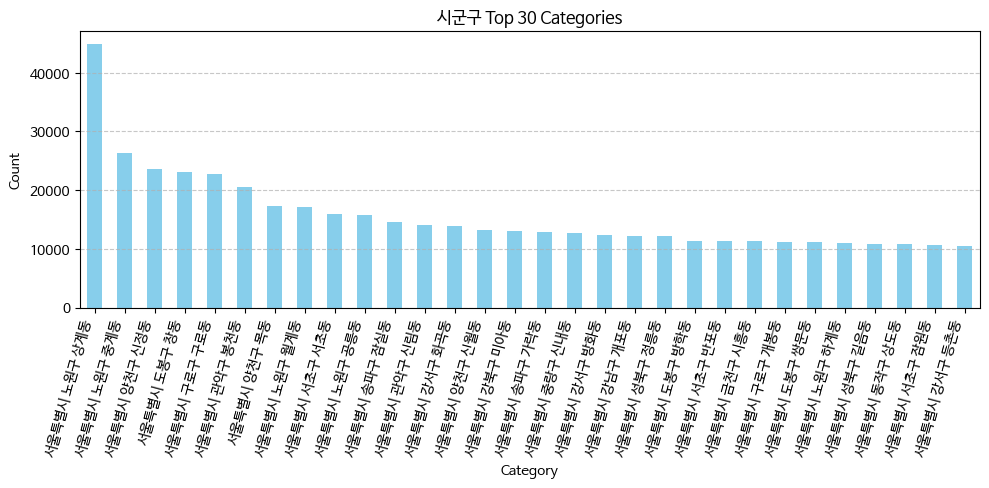

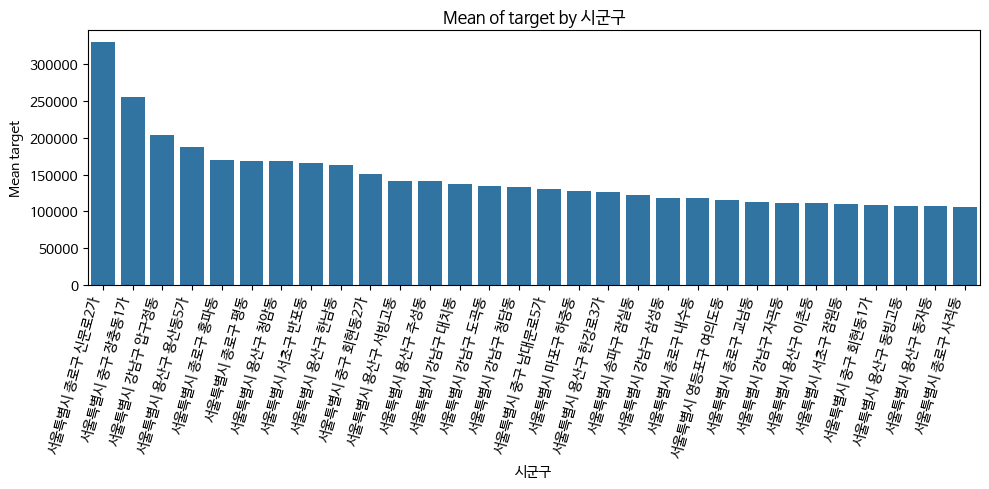

                                                  
[ 번지 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 6572
Unique (%)      : 0.59%
Missing         : 225
Missing (%)     : 0.02%
Memory size     : 64.68 MB
Rare Classes    : 6572
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 225
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
13              : 4,629, (0.41%)
17              : 4,548, (0.41%)
10              : 4,531, (0.41%)
347             : 4,264, (0.38%)
105             : 4,158, (0.37%)
...
539-5           : 1, (0.00%)
752-42          : 1, (0.00%)
3-1507          : 1, (0.00%)
1553-15         : 1, (0.00%)
792-108         : 1, (0.00%)
                                                  


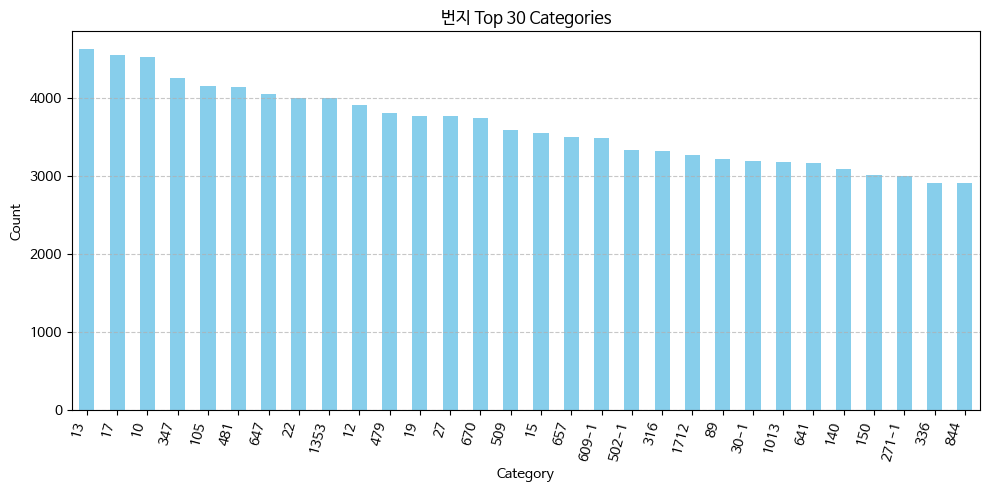

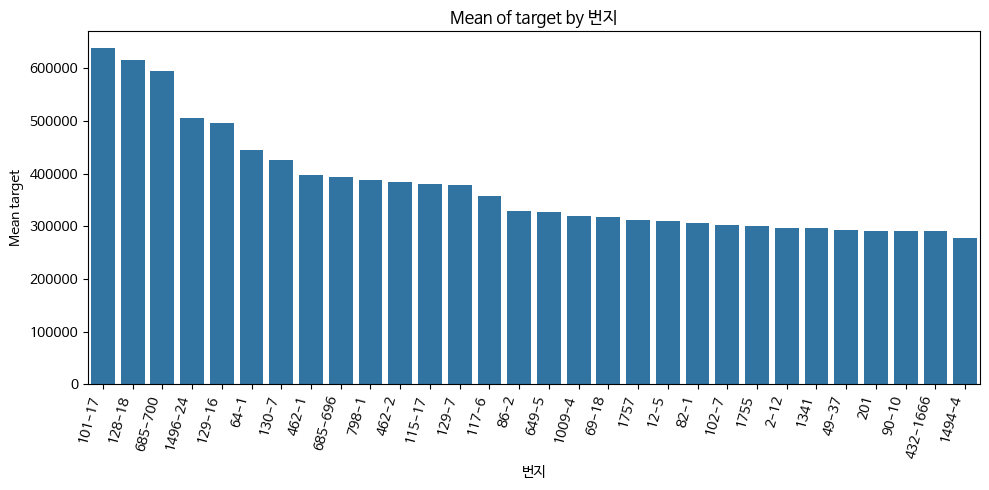

                                                  
[ 본번 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1524
Unique (%)      : 0.14%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 66.12 MB
Rare Classes    : 1524
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
30.0            : 7,035, (0.63%)
17.0            : 5,485, (0.49%)
13.0            : 5,238, (0.47%)
271.0           : 4,983, (0.45%)
1.0             : 4,947, (0.44%)
...
2015.0          : 2, (0.00%)
1200.0          : 2, (0.00%)
1486.0          : 1, (0.00%)
4974.0          : 1, (0.00%)
2039.0          : 1, (0.00%)
                                                  


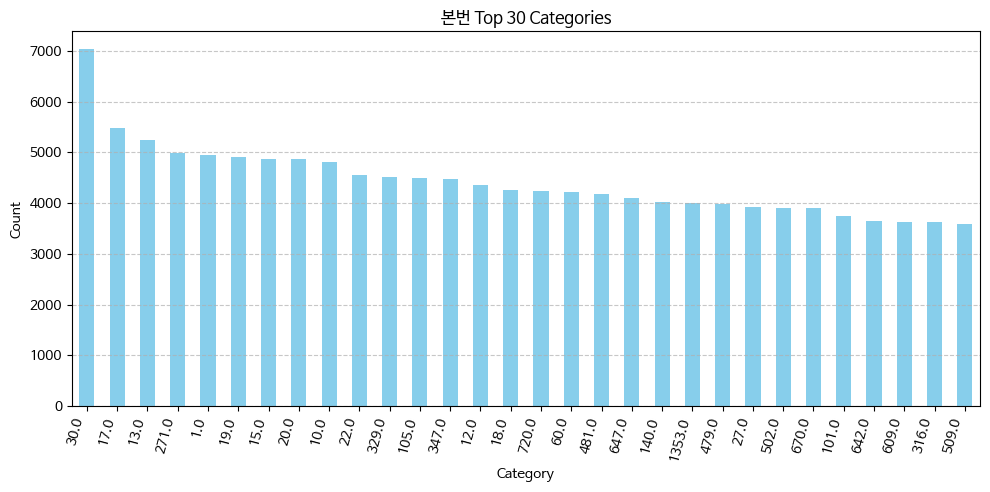

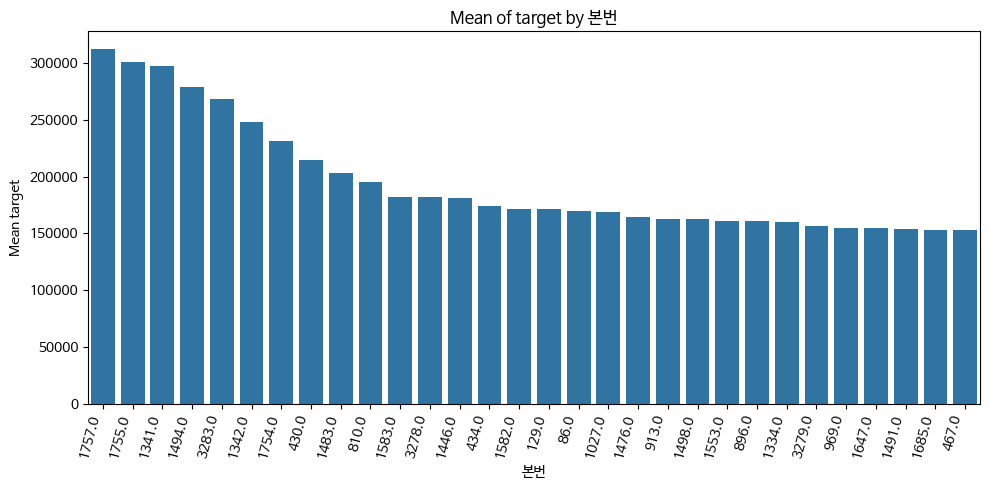

                                                  
[ 부번 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 330
Unique (%)      : 0.03%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 64.13 MB
Rare Classes    : 324
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 819,792, (73.27%)
1.0             : 94,949, (8.49%)
2.0             : 27,815, (2.49%)
3.0             : 17,983, (1.61%)
5.0             : 13,946, (1.25%)
...
174.0           : 2, (0.00%)
340.0           : 2, (0.00%)
233.0           : 1, (0.00%)
516.0           : 1, (0.00%)
1507.0          : 1, (0.00%)
                                                  


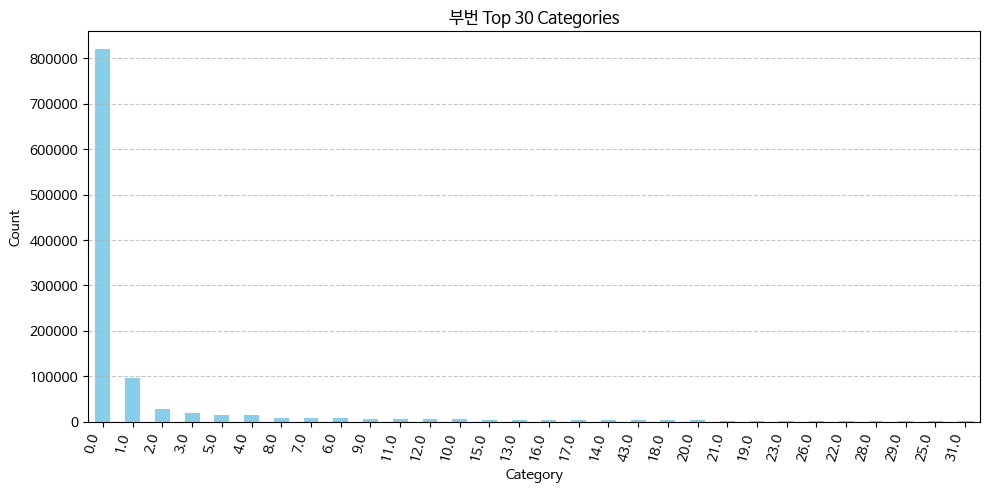

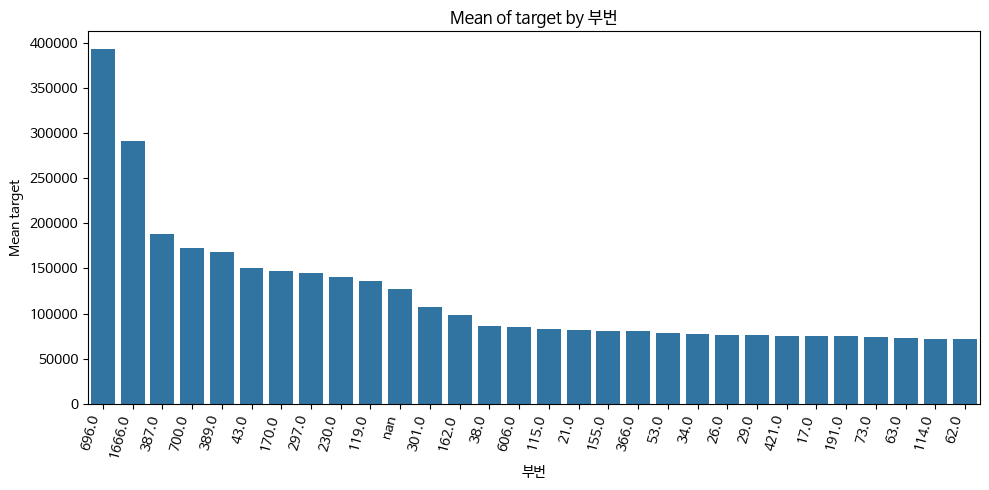

                                                  
[ 아파트명 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 6538
Unique (%)      : 0.58%
Missing         : 2126
Missing (%)     : 0.19%
Memory size     : 99.98 MB
Rare Classes    : 6536
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 2126
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
현대              : 16,644, (1.49%)
신동아             : 12,846, (1.15%)
한신              : 9,074, (0.81%)
두산              : 8,533, (0.76%)
주공2             : 7,918, (0.71%)
...
연세리버빌7차B동       : 1, (0.00%)
서울시니어스가양타워      : 1, (0.00%)
807-39          : 1, (0.00%)
밀란체             : 1, (0.00%)
신용산빌딩           : 1, (0.00%)
                                                  


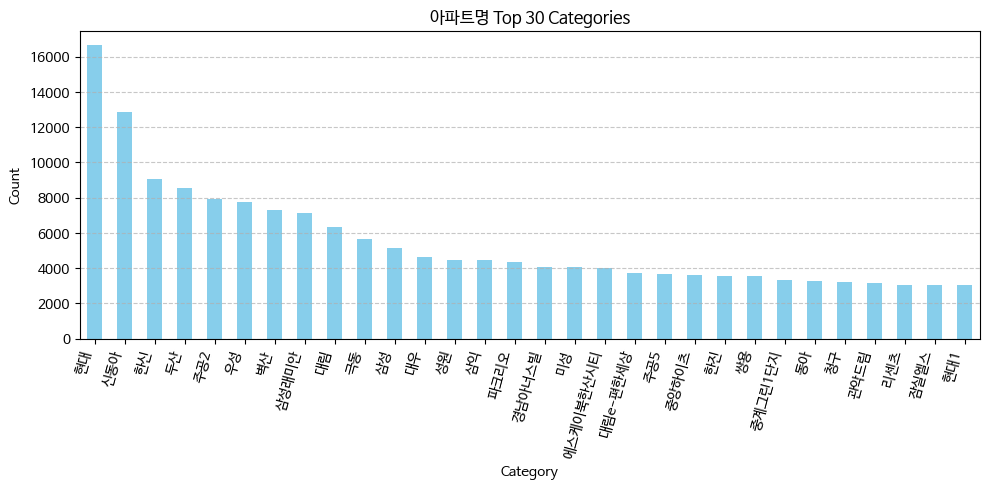

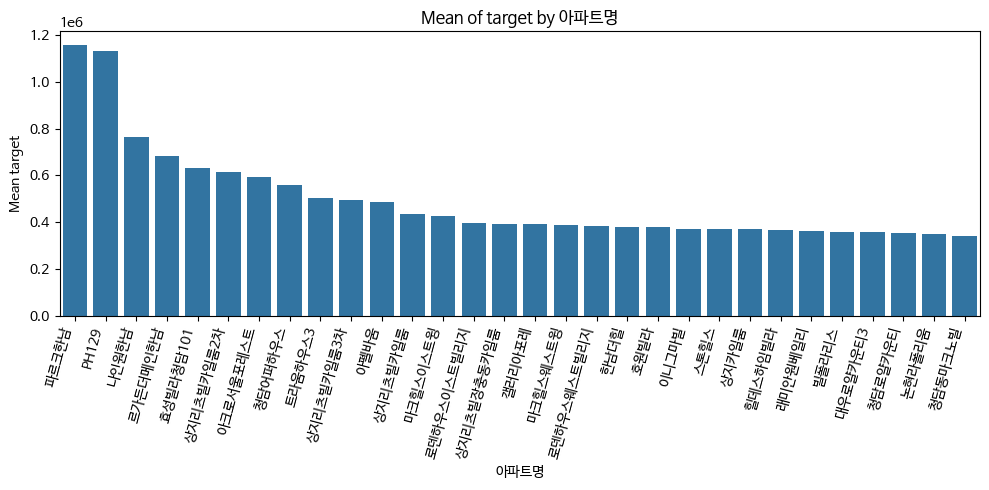

                                                  
[ 도로명 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 9232
Unique (%)      : 0.83%
Missing         : 1208
Missing (%)     : 0.11%
Memory size     : 123.99 MB
Rare Classes    : 9232
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 1208
- : 0
-------------------- Samples --------------------
올림픽로 435        : 4,322, (0.39%)
솔샘로 174         : 3,997, (0.36%)
송파대로 345        : 3,603, (0.32%)
성북로4길 52        : 3,487, (0.31%)
양재대로 1340       : 3,369, (0.30%)
...
경인로 193-17      : 1, (0.00%)
답십리로41길 7       : 1, (0.00%)
구로동로18길 44      : 1, (0.00%)
화곡로68길 102      : 1, (0.00%)
도림로8길 21        : 1, (0.00%)
                                                  


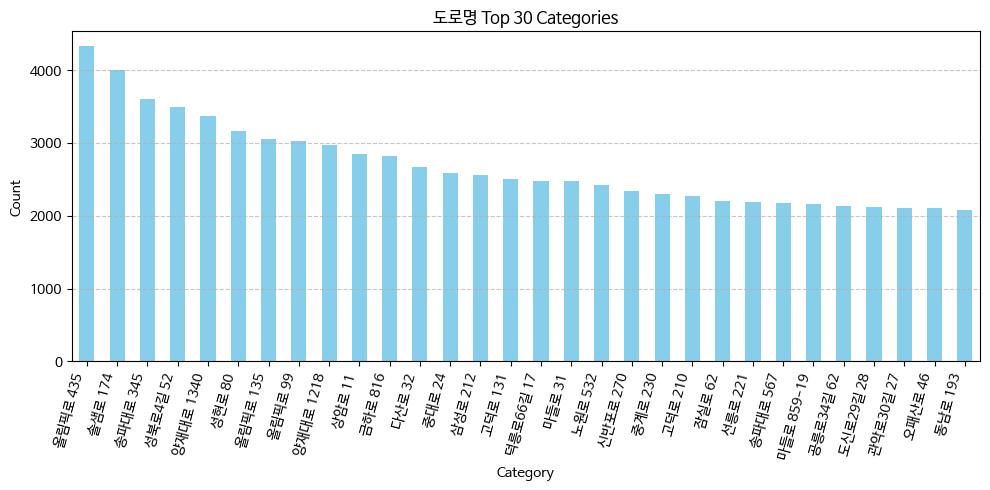

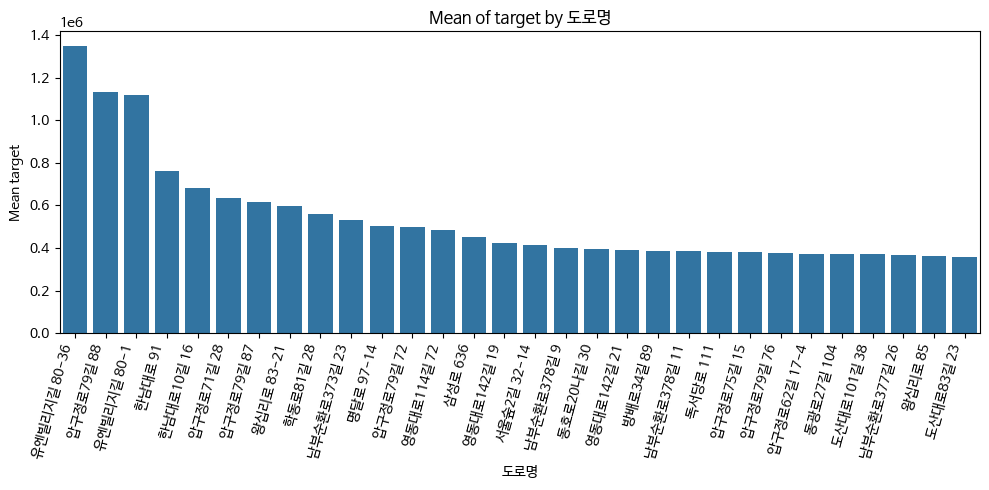

                                                  
[ k-단지분류(아파트,주상복합등등) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 5
Unique (%)      : 0.00%
Missing         : 870691
Missing (%)     : 77.82%
Memory size     : 47.47 MB
Rare Classes    : 3
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870691
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
아파트             : 235,994, (95.11%)
주상복합            : 11,360, (4.58%)
도시형 생활주택(주상복합)  : 500, (0.20%)
도시형 생활주택(아파트)   : 152, (0.06%)
연립주택            : 125, (0.05%)
                                                  


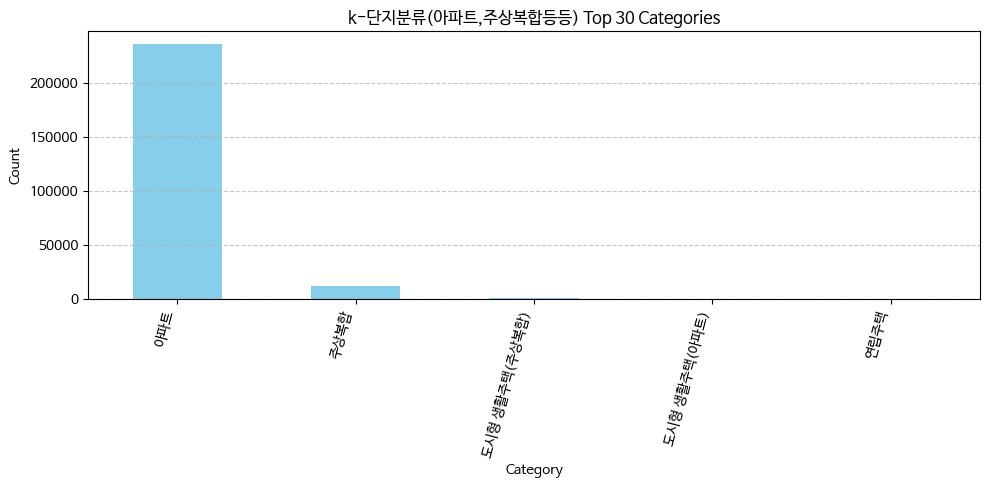

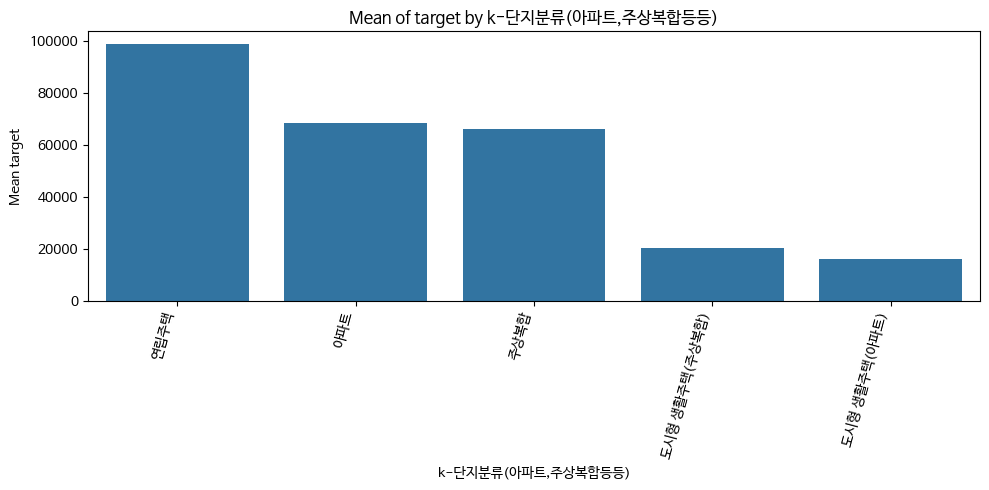

In [99]:
categorical_columns = ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)']
numerical_columns = ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일']
custom_missing_value = ['-']
for col in categorical_columns: 
    # if pd.api.types.is_numeric_dtype(df_train[col]):
    #     pass
    # else:
    if pd.api.types.is_numeric_dtype(df_train[col]):

        # for 본번, 부번 
        df_train[col] = df_train[col].astype('category') # astype(str), str or category
    feature_summary(df_train, col, custom_missing_value)
    visualize_samples_count(df_train, col)
    visualize_samples_target_mean(df_train, col)